# 02 Bound Box Detection

In [ ]:
import wget, argparse, zipfile, tarfile, sys
from pathlib import Path

def simple_progress_bar(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write("\r" + progress_message); sys.stdout.flush()

def get_and_unpack(url, location='data/'):
    Path(location).mkdir(exist_ok=True)
    filename = wget.download(url, out=location, bar=simple_progress_bar)
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(path=location)
    zip_ref.close()

In [3]:
get_and_unpack(url='http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip')

- Let's see what else we can do with fastai!
- Thanks to some hard work from the terrifice UNCC TAs, we also have bounding box annotations for each image in our dataset. 
- Let's see if we can train a deep learning model to detect bounding boxes around our bricks, balls, cylinders!
- **What modifications to our neural network do we need to make to our network to allow it make this kinda of prediction?**
- What really remarkable (as you'll see) is how little we really need to change to perform this task well. 

In [1]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


## 1. Data 

In [2]:
path=Path('data/bbc_train')

In [3]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/models'),
 PosixPath('../data/bbc_train/masks')]

In [4]:
labels=json.load(open(path/'bboxes.json', 'r'))

In [5]:
labels.keys()

dict_keys(['images', 'annotations', 'type', 'categories'])

In [6]:
labels['annotations'][12]['bbox']

[282.39102564102564, 174.0, 70.19230769230762, 67.62820512820511]

- Instead of writing our own json importer, we'll us a fastai method for this:

In [7]:
images, lbl_bbox = get_annotations(path/'bboxes.json')

In [8]:
len(images), len(lbl_bbox)

(1185, 1185)

In [9]:
images[:5]

['P2050936.jpg',
 'P2050922.jpg',
 'P2060163.jpg',
 'P2060003.jpg',
 'P2060017.jpg']

In [10]:
lbl_bbox[0]

[[[145.47435897435898,
   254.82692307692304,
   237.14102564102564,
   347.4551282051282]],
 ['ball']]

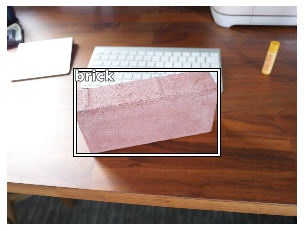

In [11]:
i=2
img = open_image(path/'images'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

- Let's setup our fastai data loading pipeline:

In [12]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [13]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'images')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [14]:
data = get_data(bs=64,size=256)

In [15]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Valid: LabelList (188 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Test: None

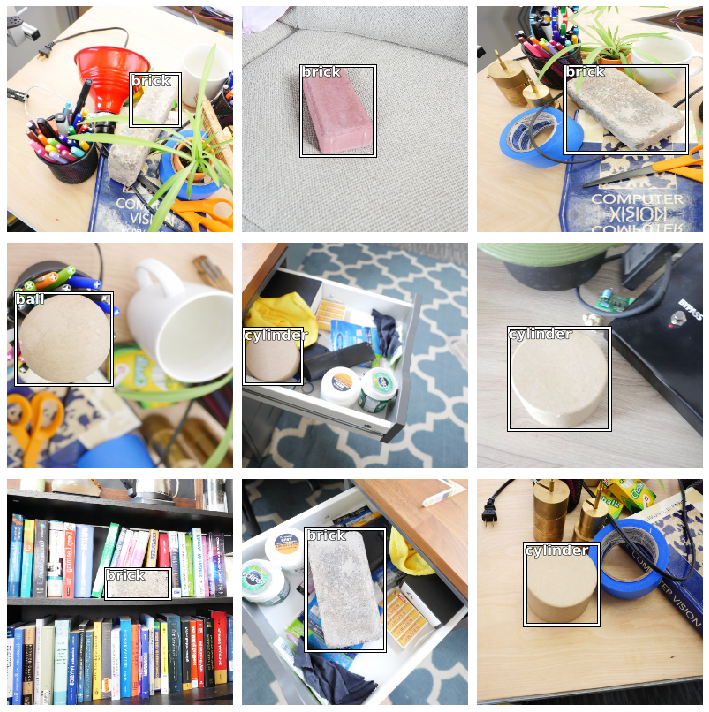

In [16]:
data.show_batch(rows=3, figsize=(10,10))

## 2. Model

- Now that our dataloading pipeline is setup, let's think about what changes we need to make to our network. 
- A nice feature of fastai is the ability to easilty attach a "custom head" to a pretrained "backbone". 
- Let's start thinking about the type of output we for our object detection network. 
- Is this a Regression or Classification Problem?
- What is the Dimenion of the output we need from our neural network?

---

- We'll create our own custom head and loss function here
- Don't worry about the exact implementation details here too much just yet - mostly pay attention to the dimensions of the inputs and outputs!
- `AdaptiveConcatPool2d` is a really nice layer that allows us to handle input images of different sizes. 

In [18]:
custom_head = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))

In [19]:
class MyLoss(nn.Module):
    def forward(self, output, bbox_tgts, class_tgts):
        return nn.L1Loss()(output.unsqueeze_(dim=1), bbox_tgts)

In [20]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss())

In [21]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [22]:
learn.freeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


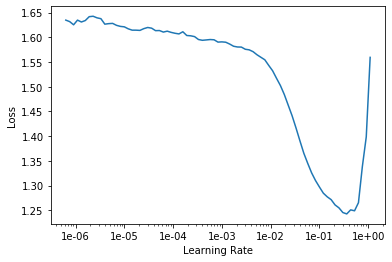

In [23]:
learn.recorder.plot()

In [23]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

In [24]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


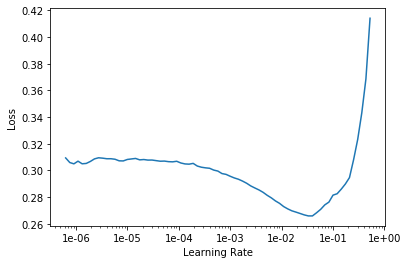

In [26]:
learn.recorder.plot()

In [27]:
lr=1e-3
learn.fit_one_cycle(8, slice(lr/10, lr))

In [28]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [30]:
learn.save('object-detector-1')

## 3. Visualize Results

In [35]:
def compute_corner_locations(y, im_shape=(256,256)):
    shape_vec=np.array(im_shape*2)
    bounds=((y+1)*shape_vec/2).ravel()
    corners=np.array([[bounds[1], bounds[0]], 
                      [bounds[3], bounds[0]],
                      [bounds[3], bounds[2]],
                      [bounds[1], bounds[2]],
                      [bounds[1], bounds[0]]])
    return corners

In [36]:
x,y = next(iter(learn.data.valid_dl))
with torch.no_grad():
    yhat = learn.model(x.to('cuda'))

In [37]:
x.shape, y[0].shape, yhat.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 1, 4]), torch.Size([64, 4]))

In [38]:
#Reshape image block and convert to numpy for visualization: 
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

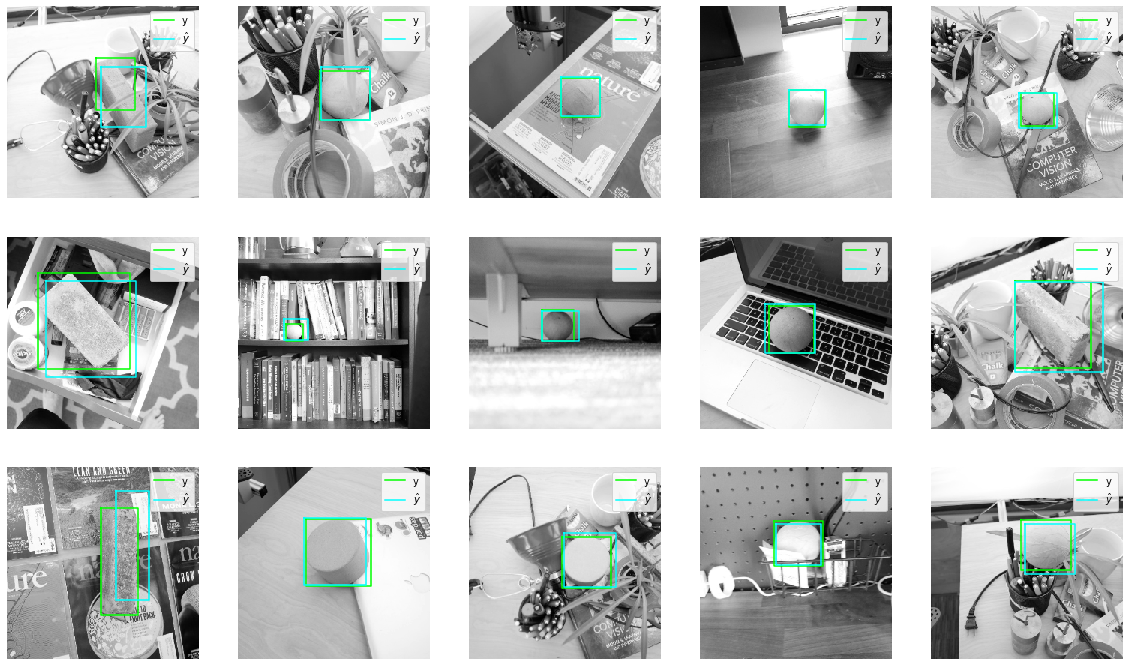

In [41]:
fig=figure(0, (20,12))
for i in range(15): 
    fig.add_subplot(3,5,i+1)
    imshow(x_numpy[i].mean(axis=2), cmap='gray')
    
    corners=compute_corner_locations(y[0][i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 0))
    
    corners=compute_corner_locations(yhat[i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 1))
    axis('off')
    legend(['y', '$\hat{y}$'])

- Not bad, right!?
- Now, there's a lot more to object detection - there's lots of ways to further improve on the performance we're achieving here. More importantly, we haven't solved object detection in the general case. **Why not?**
- This issue here is that we have no way for our algorithm to detect multple objects in the same image!
- There's alot that goes into handling multiple objects in the same image - the [SSD](https://arxiv.org/pdf/1512.02325.pdf), [Yolo](https://arxiv.org/pdf/1506.02640.pdf), and [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) papers are a great place to start learning about more sophisticated appraoches. 

## 4. Multitask Learning with fastai

- Before we wrap up our whirlwind tour of fastai, let's experiemnt with one more idea. 
- We saw how using the same pretrained resnet backbone, we can quickly specialize our network to perform varoius task. 
- Now, let's consider how we might setup our network to learn **multiple things at once** - why might we want to do this?
- Let's start by trying to group two problems we solved earlier - classification and bounding box detetection.

In [82]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['__version__', 'array', 'copy', 'uniform', 'partition', 'random', 'pad', 'subplots']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 4.1 Data

In [84]:
path=Path('../data/bbc_train')

In [85]:
path.ls()

[PosixPath('../data/bbc_train/images'),
 PosixPath('../data/bbc_train/classification_labels.csv'),
 PosixPath('../data/bbc_train/bboxes.json'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/models'),
 PosixPath('../data/bbc_train/masks')]

In [88]:
images, lbl_bbox = get_annotations(path/'bboxes.json')

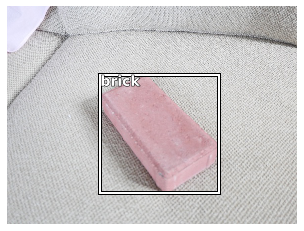

In [92]:
i=31
img = open_image(path/'images'/images[i])
bbox = ImageBBox.create(*img.size, lbl_bbox[i][0], [0], lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

In [93]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [94]:
src = ObjectItemList.from_folder(path/'images')

In [98]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(path/'images')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(max_rotate=0), size=size, tfm_y=True)
    return src.databunch(path=path, bs=bs, collate_fn=bb_pad_collate)

In [99]:
data = get_data(bs=64,size=256)

In [100]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Valid: LabelList (188 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: ../data/bbc_train/images;

Test: None

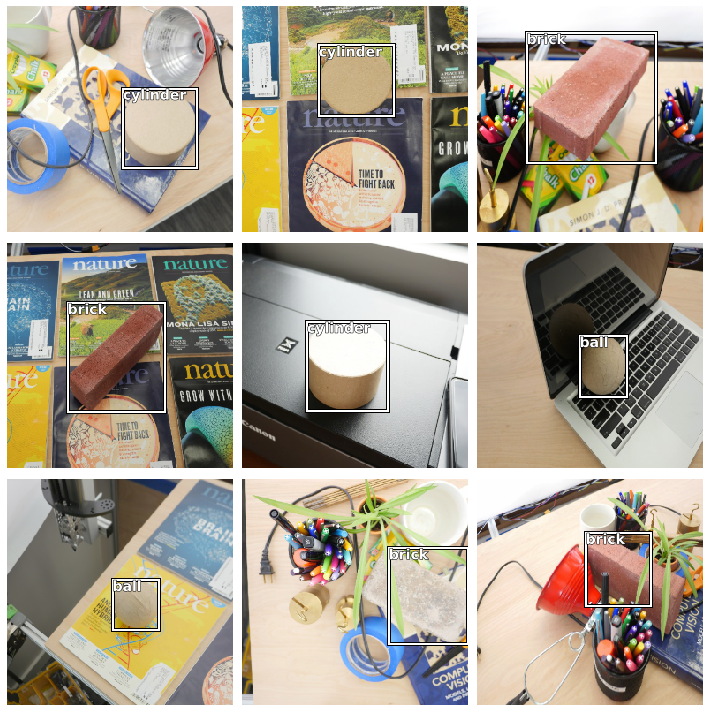

In [101]:
data.show_batch(rows=3, figsize=(10,10))

### 4.2 Model

- First, we need a loss function that takes into account both bounding box and classification performance. 
- Notize that we have a tunable balance between our two losses

In [102]:
class MyLoss(nn.Module):
    def forward(self, yhat, bbox_tgts, class_tgts):
        det_loss=nn.L1Loss()(yhat[:,:4].unsqueeze_(dim=1), bbox_tgts)
        cls_loss=nn.CrossEntropyLoss()(yhat[:,4:], class_tgts.view(-1))
        #print(det_loss, cls_loss)
        
        return det_loss + 1.0*cls_loss

In [103]:
def my_accuracy(yhat, bbox_tgts, class_tgts):
    return accuracy(yhat[:,4:], class_tgts.view(-1))

def my_l1(yhat, bbox_tgts, class_tgts):
    return nn.L1Loss()(yhat[:,:4].unsqueeze_(dim=1), bbox_tgts)

- What dimension does our output need to be to solve both classification and bounding box detection?

In [106]:
custom_head = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,8))

In [107]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss(), metrics=[my_accuracy, my_l1])

In [108]:
learn.freeze()

In [109]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


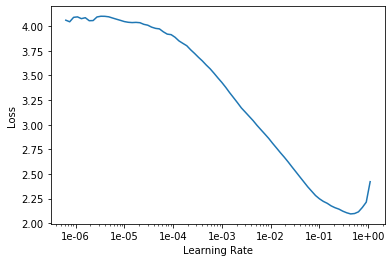

In [110]:
learn.recorder.plot()

In [111]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

In [112]:
learn.unfreeze()

In [113]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


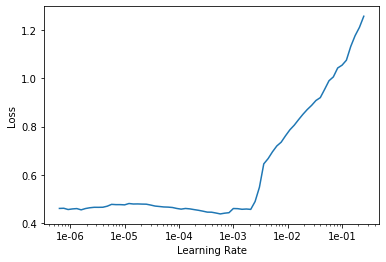

In [114]:
learn.recorder.plot()

In [115]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [116]:
lr=5e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

In [117]:
learn.save('multitask-basic-model')

### 4.3 Results

In [121]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = learn.model(x.to('cuda'))

In [122]:
x.shape, y[0].shape, yhat.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64, 1, 4]), torch.Size([64, 8]))

In [123]:
#Reshape image block and convert to numpy for visualization: 
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

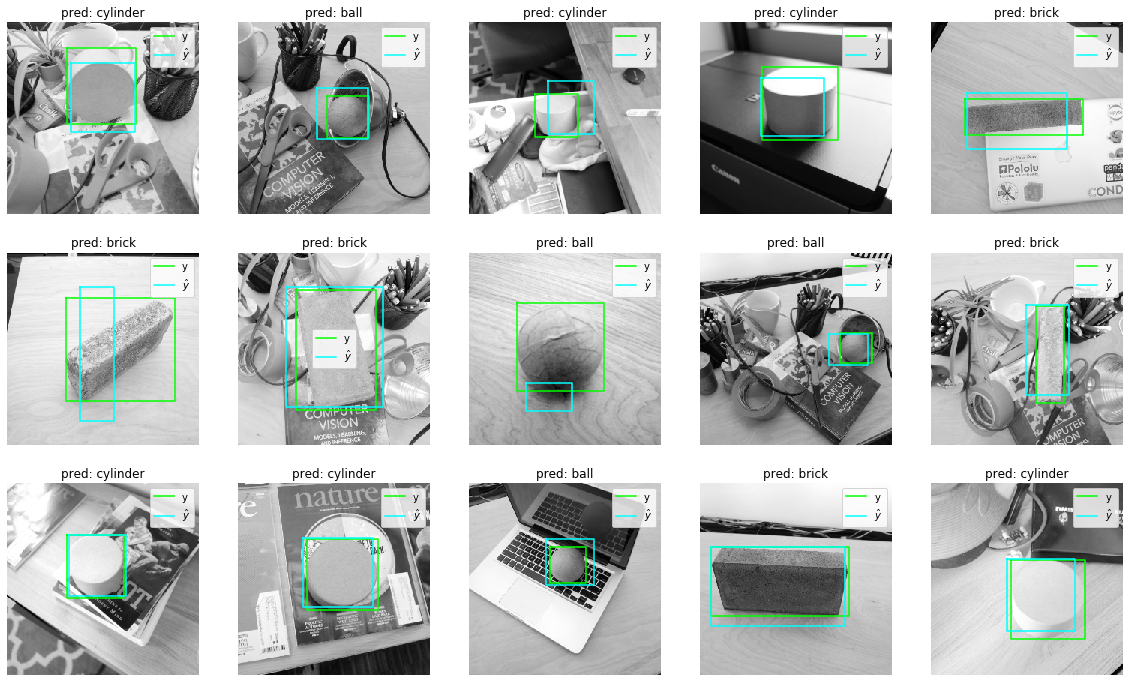

In [124]:
fig=figure(0, (20,12))
for i in range(15): 
    fig.add_subplot(3,5,i+1)
    imshow(x_numpy[i].mean(axis=2), cmap='gray')
    
    pred_class=learn.data.classes[yhat[i][4:].argmax()]
    title('pred: ' + pred_class)
    
    corners=compute_corner_locations(y[0][i].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 0))
    
    corners=compute_corner_locations(yhat[i][:4].cpu().numpy())
    plot(corners[:, 0], corners[:,1], c=(0, 1, 1)); axis('off'); legend(['y', '$\hat{y}$'])

- What other types of interesting problems could you solve with multitask learning?